In [1]:
import time
import torch
import torchvision
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torchvision import models, transforms

from IPython.display import clear_output
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange

In [2]:
SEED = 0xDEAD
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

#### Data

In [3]:
batch_size = 512

transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {"train": len(trainset), "test": len(testset)}

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

dataset_sizes

Files already downloaded and verified
Files already downloaded and verified


{'train': 50000, 'test': 10000}

#### Utils

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def plot_training_progress(
    train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history
):
    clear_output(wait=True)

    epoch = len(train_loss_history) - 1

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, "-x", label="train")
    plt.plot(test_loss_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Loss")
    plt.grid(linewidth=0.1)

    current_train_loss = train_loss_history[-1]
    current_test_loss = test_loss_history[-1]

    plt.text(
        epoch, current_train_loss, f"{current_train_loss:.3f}", va="center", ha="right"
    )
    plt.text(
        len(test_loss_history) - 1,
        current_test_loss,
        f"{current_test_loss:.3f}",
        va="center",
        ha="right",
    )

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, "-x", label="train")
    plt.plot(test_accuracy_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.grid(linewidth=0.1)

    current_train_accuracy = train_accuracy_history[-1]
    current_test_accuracy = test_accuracy_history[-1]

    plt.text(
        epoch,
        current_train_accuracy,
        f"{current_train_accuracy:.2f}%",
        va="center",
        ha="right",
    )
    plt.text(
        epoch,
        current_test_accuracy,
        f"{current_test_accuracy:.2f}%",
        va="center",
        ha="right",
    )

    plt.tight_layout()
    plt.show()

In [6]:
def train_one_epoch(model, trainloader, criterion, optimizer, scheduler=None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
    if scheduler:
        scheduler.step()

    return total_loss / len(trainloader), 100 * correct / total_samples

In [7]:
def evaluate(model, testloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(testloader), (correct / total_samples) * 100

In [8]:
def train_and_evaluate(
    model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=10,
    model_name=None,
    phase="first",
):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_one_epoch(
            model, trainloader, criterion, optimizer, scheduler
        )
        test_loss, test_accuracy = evaluate(model, testloader, criterion)
        end_time = time.time()

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)
        epoch_times.append(end_time - start_time)

        plot_training_progress(
            train_loss_history,
            test_loss_history,
            train_accuracy_history,
            test_accuracy_history,
        )

        print(
            "{} on {} phase\n"
            "Epoch {}/{} Epoch Time: {:.2f} sec.\n"
            "Train Loss: {:.3f} Train Accuracy: {:.2f}%\n"
            "Test Loss: {:.3f} Test Accuracy: {:.2f}%".format(
                model_name,
                phase,
                epoch + 1,
                num_epochs,
                epoch_times[-1],
                train_loss,
                train_accuracy,
                test_loss,
                test_accuracy,
            )
        )

    total_training_time = sum(epoch_times)
    avg_epoch_time = total_training_time / num_epochs

    print(
        f"Total train time: {total_training_time:.2f} sec.\n"
        f"Average epoch time: {avg_epoch_time:.2f} sec."
    )

    return (test_accuracy_history[-1], num_epochs, total_training_time, phase)

In [9]:
def find_last_linear(model):
    last_linear_info = None
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Linear):
            last_linear_info = (name, module)
            if "." in name:
                parts = name.split(".")
                last_linear_info = (parts[0], int(parts[1]), module)
    return last_linear_info

In [10]:
def modify_model(model, phase="first"):
    last_linear_info = find_last_linear(model)

    print(f"Last layer: {last_linear_info}")

    if phase == "first":
        for param in model.parameters():
            param.requires_grad = False

    if last_linear_info:
        out_features = 10
        if len(last_linear_info) == 2:
            last_linear_name, last_linear = last_linear_info
            model._modules[last_linear_name] = nn.Linear(
                last_linear.in_features, out_features
            ).to(device)
            print(f"Modified Last Layer: {model._modules[last_linear_name]}")
            for param in last_linear.parameters():
                param.requires_grad = True
        elif len(last_linear_info) == 3:
            seq_name, seq_index, last_linear = last_linear_info
            seq = model._modules[seq_name]
            seq[seq_index] = nn.Linear(last_linear.in_features, out_features).to(device)
            print(f"Modified Last Layer in Sequential: {seq[seq_index]}")
            for param in seq[seq_index].parameters():
                param.requires_grad = True
    return model

In [11]:
def count_print_trainable_params(model):
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of Trainable Parameters: {num_trainable_params}\n")

### Pretrained models

In [12]:
warnings.filterwarnings(
    "ignore", category=UserWarning, module="torchvision.models._utils"
)

In [13]:
pretrained_models = {
    "resnet18": models.resnet18(pretrained=True).to(device),
    "resnext50_32x4d": models.resnext50_32x4d(pretrained=True).to(device),
    "mobilenet_v2": models.mobilenet_v2(pretrained=True).to(device),
    "efficientnet_v2_s": models.efficientnet_v2_s(pretrained=True).to(device),
}

# for model_name, model in pretrained_models.items():
#     torch.save(model.state_dict(), f"{model_name}_pretrained.pth")

non_pretrained_models = {
    "resnet18": models.resnet18(pretrained=False).to(device),
    "resnext50_32x4d": models.resnext50_32x4d(pretrained=False).to(device),
    "mobilenet_v2": models.mobilenet_v2(pretrained=False).to(device),
    "efficientnet_v2_s": models.efficientnet_v2_s(pretrained=False).to(device),
}

### Train and evaluate

In [14]:
model_params = {
    "resnet18": {
        "lr": 1e-3,
        "momentum": 0.9,
        "weight_decay": 5e-5,
        "step_size": 50,
        "gamma": 0.1,
        "num_epoch": 60,
    },
    "resnext50_32x4d": {
        "lr": 1e-2,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "step_size": 30,
        "gamma": 0.1,
        "num_epoch": 50,
    },
    "mobilenet_v2": {
        "lr": 1e-1,
        "momentum": 0.9,
        "weight_decay": 4e-5,
        "scheduler": None,
        "num_epoch": 25,
    },
    "efficientnet_v2_s": {
        "lr": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "scheduler": None,
        "num_epoch": 20,
    },
}

In [15]:
results_frozen = {}
results_from_scratch = {}


def create_train_params(
    model_name, lr, momentum, weight_decay, step_size, gamma, num_epochs, phase
):
    if phase == "first":
        model = pretrained_models.get(model_name, None)

    elif phase == "second":
        model = non_pretrained_models.get(model_name, None)

    if model is None:
        print(f"Model {model_name} not found")
        return

    clear_output(wait=True)
    print(f"{model_name} on phase {phase}\n")
    modify_model(model, phase)
    count_print_trainable_params(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay
    )

    if step_size and gamma:
        scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=step_size, gamma=gamma
        )
    else:
        scheduler = None

    results = train_and_evaluate(
        model,
        trainloader,
        testloader,
        criterion,
        optimizer,
        scheduler,
        num_epochs,
        model_name,
        phase
    )

    if phase == "first":
        results_frozen[model_name] = results
    elif phase == "second":
        results_from_scratch[model_name] = results

In [16]:
def train_model_with_params(model_name, phase):
    params = model_params.get(model_name, {})
    lr = params.get("lr", 1e-3)
    momentum = params.get("momentum", 0.9)
    weight_decay = params.get("weight_decay", 5e-5)
    step_size = params.get("step_size", None)
    gamma = params.get("gamma", None)
    num_epochs = params.get("num_epoch", 30)
    create_train_params(
        model_name, lr, momentum, weight_decay, step_size, gamma, num_epochs, phase
    )

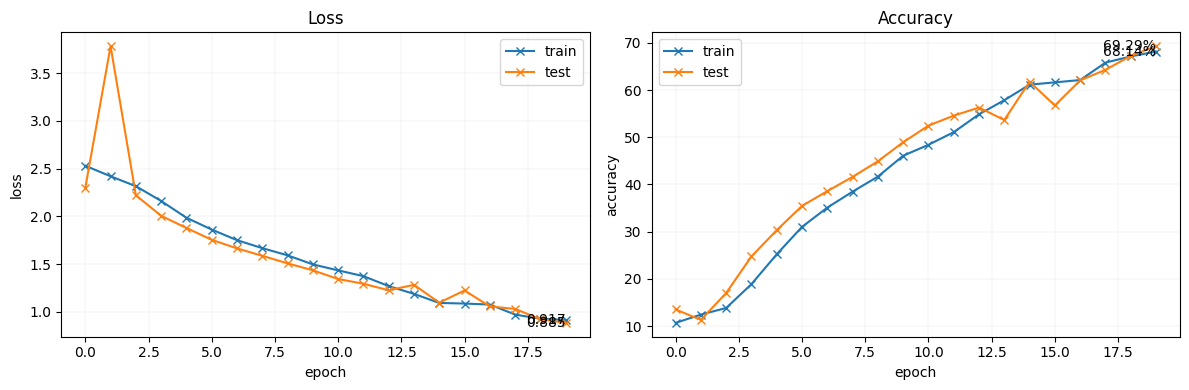

Epoch 20 Epoch Time: 16.83 sec.
Train Loss: 0.917 Train Accuracy: 68.14%
Test Loss: 0.885 Test Accuracy: 69.29%
Total train time: 337.56 sec.
Average epoch time: 16.88 sec.


In [17]:
model_names = ["resnet18", "resnext50_32x4d", "mobilenet_v2", "efficientnet_v2_s"]

for model_name in model_names:
    for phase in ["first", "second"]:
        train_model_with_params(model_name, phase)

In [18]:
results_frozen_df = pd.DataFrame(results_frozen)
results_frozen_df.to_csv("pw2_frozen.csv", index=False)

results_from_scratch_df = pd.DataFrame(results_from_scratch)
results_from_scratch_df.to_csv("pw2_scratch.csv", index=False)

### Results

In [19]:
# results_frozen_df = pd.read_csv("pw2_frozen.csv")
# results_from_scratch_df = pd.read_csv("pw2_scratch.csv")

result_df = pd.concat(
    [results_frozen_df.iloc[:1], results_from_scratch_df.iloc[:1]], axis=0
)

pw1_results = pd.read_csv("pw1_results.csv")
result_df.reset_index(drop=True, inplace=True)
pw1_results.reset_index(drop=True, inplace=True)
pw1_results.rename(columns={"0": "similar_to_AlexNet"}, inplace=True)


all_results = pd.concat([result_df, pw1_results], axis=1)
all_results

,resnet18,resnext50_32x4d,mobilenet_v2,efficientnet_v2_s,similar_to_AlexNet
0,47.71,46.65,31.63,26.74,89.53
1,68.77,69.61,69.64,69.29,87.57


In [20]:
all_results = all_results.T.reset_index()
all_results.columns = ["model", "first", "second"]
all_results

,model,first,second
0,resnet18,47.71,68.77
1,resnext50_32x4d,46.65,69.61
2,mobilenet_v2,31.63,69.64
3,efficientnet_v2_s,26.74,69.29
4,similar_to_AlexNet,89.53,87.57


In [21]:
all_results["first"] = all_results["first"].astype(float).round(0).astype(int)
all_results["second"] = all_results["second"].astype(float).round(0).astype(int)
melted_results = all_results.melt(
    id_vars="model", var_name="experiment", value_name="accuracy"
)
melted_results

,model,experiment,accuracy
0,resnet18,first,48
1,resnext50_32x4d,first,47
2,mobilenet_v2,first,32
3,efficientnet_v2_s,first,27
4,similar_to_AlexNet,first,90
5,resnet18,second,69
6,resnext50_32x4d,second,70
7,mobilenet_v2,second,70
8,efficientnet_v2_s,second,69
9,similar_to_AlexNet,second,88


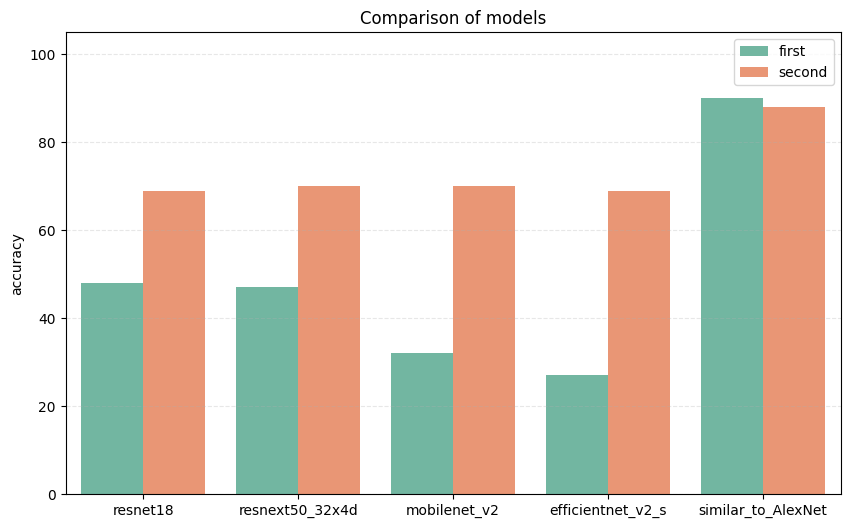

In [22]:
palette = sns.color_palette("Set2", 2)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=melted_results, x="model", y="accuracy", hue="experiment", palette=palette
)

plt.title("Comparison of models")
plt.ylim(0, 105)
plt.xlabel("")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.show()